##  Weather Forecasting
## Timeseries - LSTM model
### Gamze Keçibaş
---
### CONTENT
- **Step 01.** Import libraries
- **Step 02.** Import data
- **Step 03.** Data visualization
- **Step 04.** Check feature correlation
- **Step 05.** Data preprocessing
- **Step 06.** Training and Validation datasets
- **Step 07.** Model training
- **Step 08.** Plotting
- **Step 09.** Predictions
---
### [resource](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)

### Step 01. Import libraries 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Step 02. Import data 
- jena_climate_2009_2016 dataset is used.

In [2]:
data_dir= r'C:\Users\gkeciba1\Desktop'
fname= os.path.join(data_dir, 'jena_climate_2009_2016.xls')
f=open(fname)
data= f.read()
f.close()

lines= data.split('\n')
header= lines[0].split(',')
lines= lines[1:]
df = pd.read_csv(fname)

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Step 03. Data visualization
- Define titles, feature keys and plot

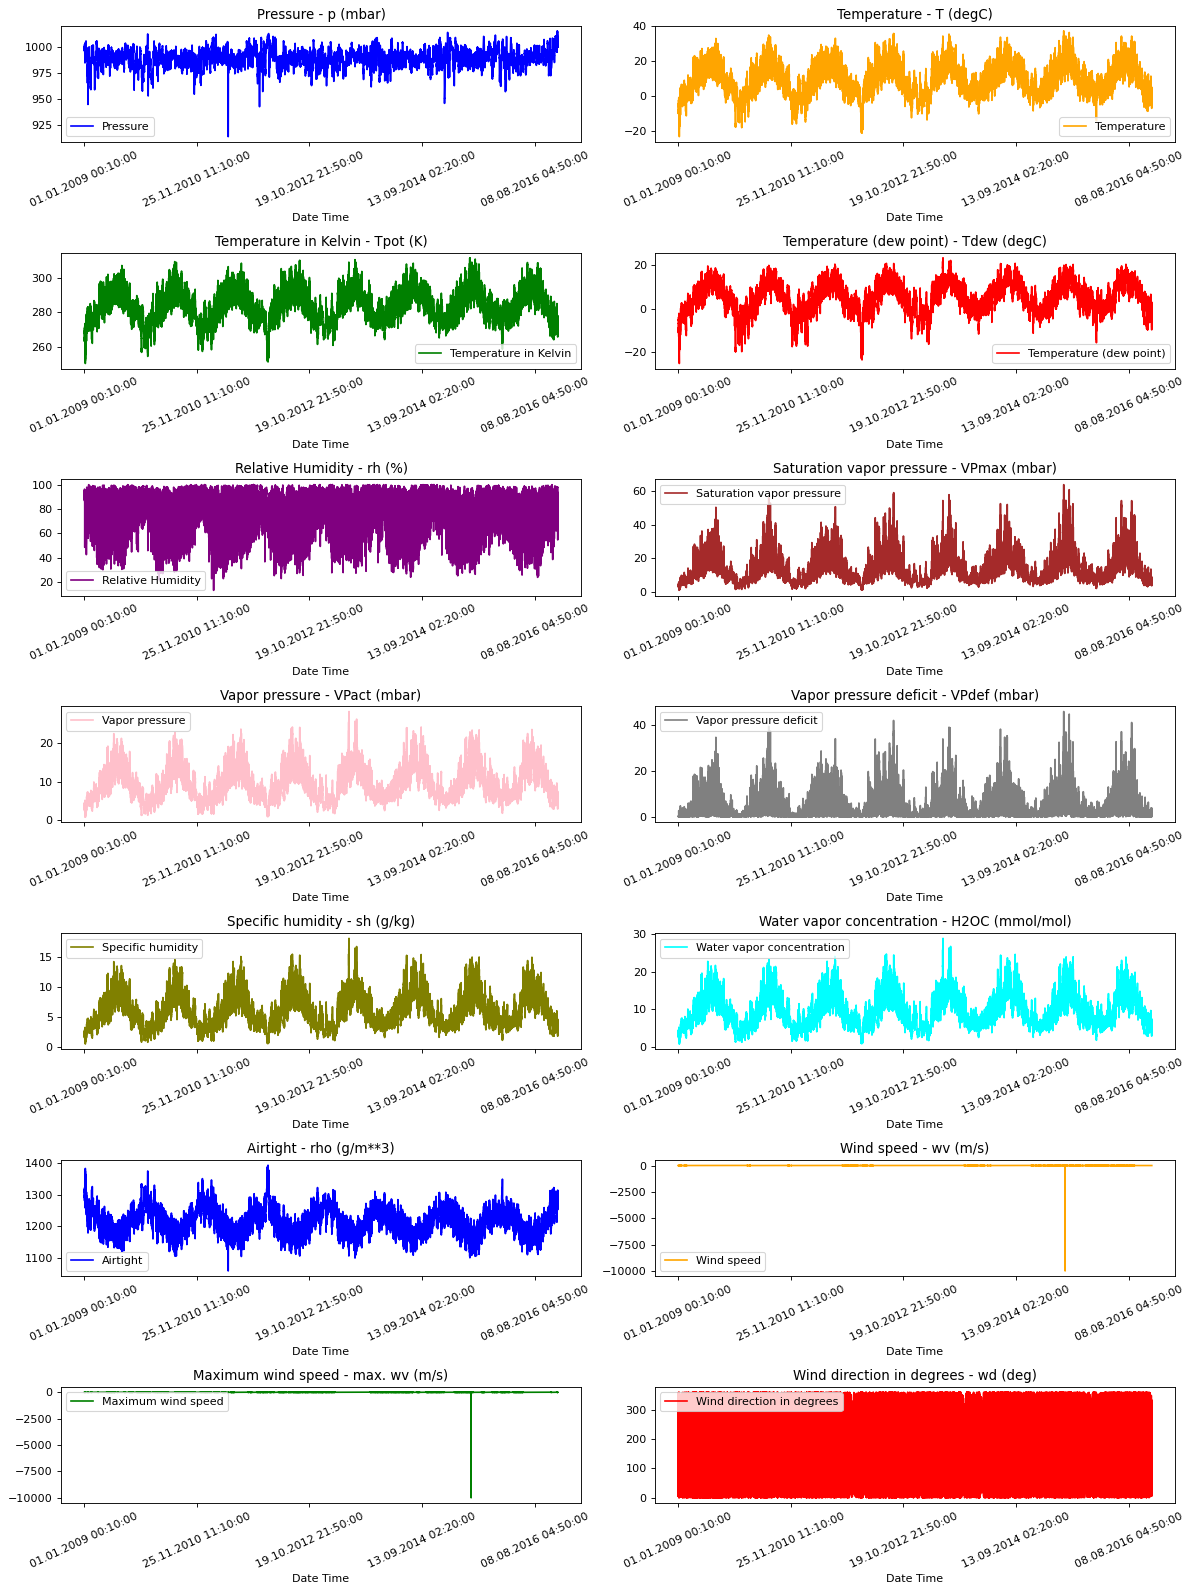

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


time_data = df[date_time_key]
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
for i in range(len(feature_keys)):
    key = feature_keys[i]
    c = colors[i % (len(colors))]
    t_data = df[key]
    t_data.index = time_data
    t_data.head()
    ax = t_data.plot(
    ax=axes[i // 2, i % 2],
    color=c,
    title="{} - {}".format(titles[i], key), rot=25,)
    ax.legend([titles[i]])
    plt.tight_layout()




### Step 04. Check feature correlation

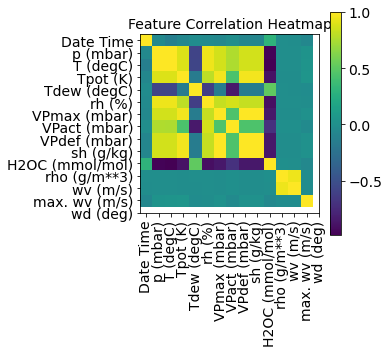

In [4]:
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

### Step 05. Data preprocessing

In [5]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 128
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


### Step 06. Training and Validation datasets

In [6]:
# Define training dataset
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Define validation dataset
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 120, 7)
Target shape: (128, 1)


### Step 07. Model training

In [7]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(14)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1232      
_________________________________________________________________
dense (Dense)                (None, 1)                 15        
Total params: 1,247
Trainable params: 1,247
Non-trainable params: 0
_________________________________________________________________


In [8]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))

Epoch 1/10
2623/2623 [==============================] - 96s 36ms/step - loss: 0.2284 - val_loss: 0.2025

Epoch 00001: val_loss improved from inf to 0.20251, saving model to model_checkpoint.h5
Epoch 2/10
2623/2623 [==============================] - 92s 35ms/step - loss: 0.1419 - val_loss: 0.1845

Epoch 00002: val_loss improved from 0.20251 to 0.18447, saving model to model_checkpoint.h5
Epoch 3/10
2623/2623 [==============================] - 91s 35ms/step - loss: 0.1244 - val_loss: 0.1762

Epoch 00003: val_loss improved from 0.18447 to 0.17619, saving model to model_checkpoint.h5
Epoch 4/10
2623/2623 [==============================] - 98s 38ms/step - loss: 0.1164 - val_loss: 0.1730

Epoch 00004: val_loss improved from 0.17619 to 0.17300, saving model to model_checkpoint.h5
Epoch 5/10
2623/2623 [==============================] - 100s 38ms/step - loss: 0.1130 - val_loss: 0.1747

Epoch 00005: val_loss did not improve from 0.17300
Epoch 6/10
2623/2623 [==============================] - 90s

In [9]:
# GRU- based model

model_gru = keras.models.Sequential()
model_gru.add(keras.layers.GRU(14, input_shape=(None, inputs.shape[-1])))
model_gru.add(keras.layers.Dense(1))

model_gru.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model_gru.summary()

path_checkpoint_gru = "model_checkpoint_gru.h5"
es_callback_gru = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback_gru = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_gru = model_gru.fit(dataset_train, 
                            epochs=10, 
                            validation_data=dataset_val,
                            callbacks=[es_callback_gru, modelckpt_callback_gru],)

loss_gru = history_gru.history["loss"]
val_loss_gru = history_gru.history["val_loss"]
epochs_gru = range(len(loss_gru))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 14)                966       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2623/2623 [==============================] - 111s 42ms/step - loss: 0.2980 - val_loss: 0.1879

Epoch 00001: val_loss improved from inf to 0.18790, saving model to model_checkpoint.h5
Epoch 2/10
2623/2623 [==============================] - 102s 39ms/step - loss: 0.1412 - val_loss: 0.1647

Epoch 00002: val_loss improved from 0.18790 to 0.16470, saving model to model_checkpoint.h5
Epoch 3/10
2623/2623 [==============================] - 101s 39ms/step - loss: 0.1215 - val_loss: 0.1612

Epoch 00003: val_loss 

In [10]:
# GRU- based model with dropout- regularized

model_gru_drop = keras.models.Sequential()
model_gru_drop.add(keras.layers.GRU(14, dropout= 0.2, recurrent_dropout= 0.2, input_shape=(None, inputs.shape[-1])))
model_gru_drop.add(keras.layers.Dense(1))

model_gru_drop.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model_gru_drop.summary()

path_checkpoint_gru_drop = "model_checkpoint_gru_drop.h5"
es_callback_gru_drop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback_gru_drop = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_gru_drop = model_gru_drop.fit(dataset_train, 
                            epochs=10, 
                            validation_data=dataset_val,
                            callbacks=[es_callback_gru_drop, modelckpt_callback_gru_drop],)

loss_gru_drop = history_gru_drop.history["loss"]
val_loss_gru_drop = history_gru_drop.history["val_loss"]
epochs_gru_drop = range(len(loss_gru_drop))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 14)                966       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2623/2623 [==============================] - 176s 66ms/step - loss: 0.2365 - val_loss: 0.2165

Epoch 00001: val_loss improved from inf to 0.21650, saving model to model_checkpoint.h5
Epoch 2/10
2623/2623 [==============================] - 178s 68ms/step - loss: 0.1633 - val_loss: 0.1691

Epoch 00002: val_loss improved from 0.21650 to 0.16909, saving model to model_checkpoint.h5
Epoch 3/10
2623/2623 [==============================] - 174s 66ms/step - loss: 0.1441 - val_loss: 0.1552

Epoch 00003: val_los

In [11]:
# Combining CNN and RNN -> 1D convnet

model_convnet= keras.models.Sequential()
model_convnet.add(keras.layers.Conv1D(14,5, activation = 'relu', input_shape= (None, inputs.shape[-1])))
model_convnet.add(keras.layers.MaxPooling1D(3))
model_convnet.add(keras.layers.Conv1D(14,5, activation = 'relu', input_shape= (None, inputs.shape[-1])))
model_convnet.add(keras.layers.MaxPooling1D(3))
model_convnet.add(keras.layers.Conv1D(14,5, activation = 'relu', input_shape= (None, inputs.shape[-1])))
model_convnet.add(keras.layers.GlobalMaxPooling1D())
model_convnet.add(keras.layers.Dense(1))

model_convnet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model_convnet.summary()

path_checkpoint_convnet = "model_checkpoint_convnet.h5"
es_callback_convnet = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback_convnet = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_convnet= model.fit(dataset_train, 
                            epochs=10, 
                            validation_data=dataset_val,
                            callbacks=[es_callback_convnet, modelckpt_callback_convnet],)

loss_convnet = history_convnet.history["loss"]
val_loss_convnet = history_convnet.history["val_loss"]
epochs_convnet = range(len(loss_convnet))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 14)          504       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 14)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 14)          994       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 14)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 14)          994       
_________________________________________________________________
global_max_pooling1d (Global (None, 14)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
# GRU model with 1D convnet 

model_gru_convnet = keras.models.Sequential()
model_gru_convnet.add(keras.layers.Conv1D(14,5, activation = 'relu', input_shape= (None, inputs.shape[-1])))
model_gru_convnet.add(keras.layers.MaxPooling1D(3))
model_gru_convnet.add(keras.layers.Conv1D(14,5, activation = 'relu', input_shape= (None, inputs.shape[-1])))
model_gru_convnet.add(keras.layers.GRU(14, dropout= 0.1, recurrent_dropout=0.5))
model_gru_convnet.add(keras.layers.Dense(1))

model_gru_convnet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model_gru_convnet.summary()

path_checkpoint_gru_convnet = "model_checkpoint_gru_convnet.h5"
es_callback_gru_convnet = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback_gru_convnet = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_gru_convnet = model_gru_convnet.fit(dataset_train, 
                            epochs=200, 
                            validation_data=dataset_val,
                            callbacks=[es_callback_gru_convnet, modelckpt_callback_gru_convnet],)

loss_gru_convnet = history_gru_convnet.history["loss"]
val_loss_gru_convnet = history_gru_convnet.history["val_loss"]
epochs_gru_convnet = range(len(loss_gru_convnet))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 14)          504       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 14)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 14)          994       
_________________________________________________________________
gru_2 (GRU)                  (None, 14)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 15        
Total params: 2,773
Trainable params: 2,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2623/2623 [==============================] - 73s 27ms/step - loss: 0.1936 - val_loss: 0.2564

Epoch 00001:

### Step 08. Plotting

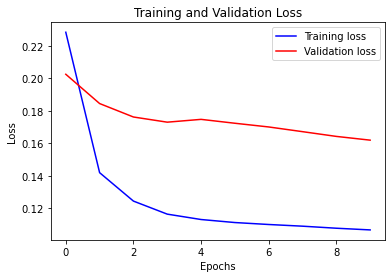

<Figure size 432x288 with 0 Axes>

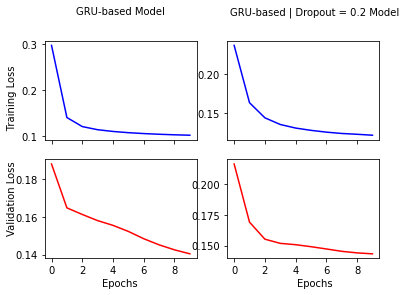

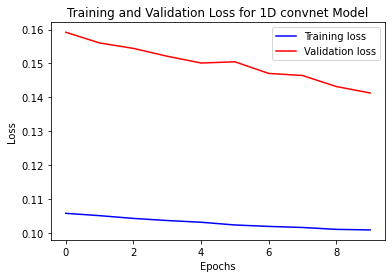

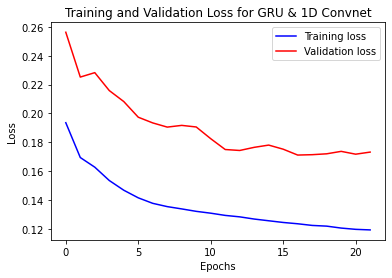

In [13]:
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
fig, axs= plt.subplots(2,2, sharex= True, sharey= False)
axs[0,0].plot(epochs_gru, loss_gru, "b", label="Training loss")
axs[1,0].plot(epochs_gru, val_loss_gru, "r", label="Validation loss")
axs[0,1].plot(epochs_gru_drop, loss_gru_drop, "b", label="Training loss")
axs[1,1].plot(epochs_gru_drop, val_loss_gru_drop, "r", label="Validation loss")

plt.figtext(.300,1, "GRU-based Model\n", ha="center", va="top", fontsize=10)
plt.figtext(.750,1, "GRU-based | Dropout = 0.2 Model\n", ha="center", va="top", fontsize=10)
fig.text(0.300, 0.04, 'Epochs', ha='center', va='center')
fig.text(0.750, 0.04, 'Epochs', ha='center', va='center')
fig.text(0.05, 0.5, 'Validation Loss          Training Loss', ha='center', va='center', rotation='vertical')
plt.show()

plt.figure()
plt.plot(epochs_convnet, loss_convnet, "b", label="Training loss")
plt.plot(epochs_convnet, val_loss_convnet, "r", label="Validation loss")
plt.title("Training and Validation Loss for 1D convnet Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_gru_convnet, loss_gru_convnet, "b", label="Training loss")
plt.plot(epochs_gru_convnet, val_loss_gru_convnet, "r", label="Validation loss")
plt.title("Training and Validation Loss for GRU & 1D Convnet")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Step 09. Predictions

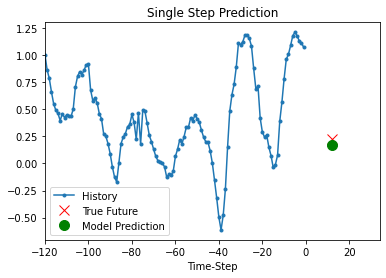

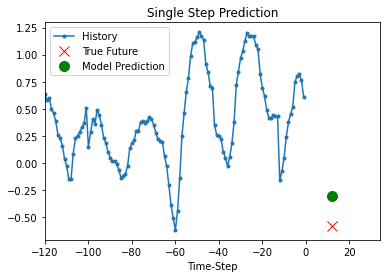

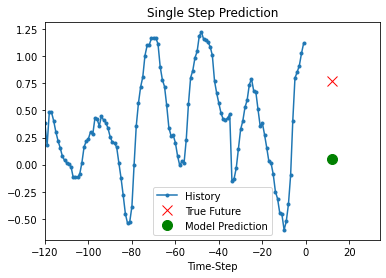

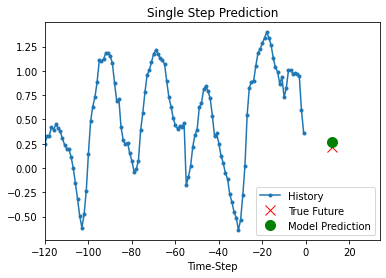

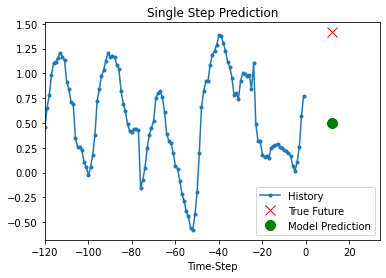

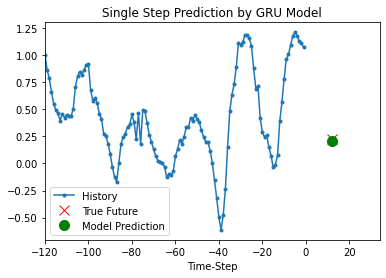

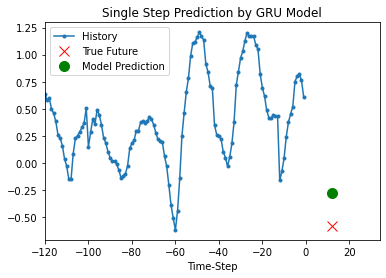

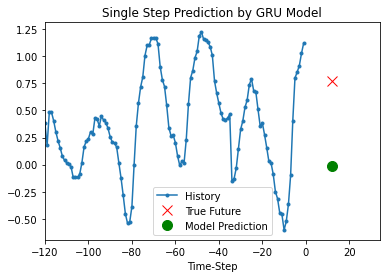

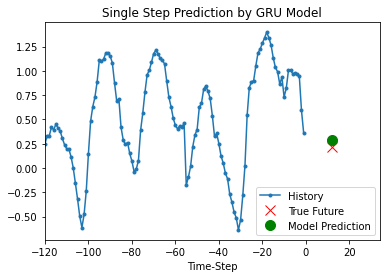

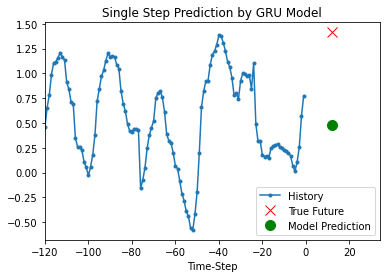

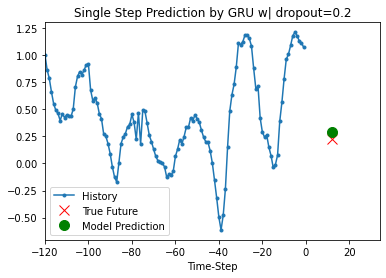

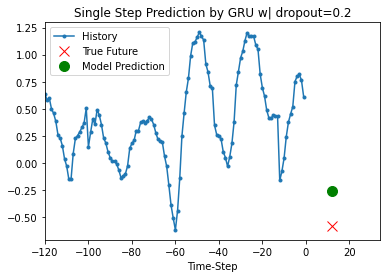

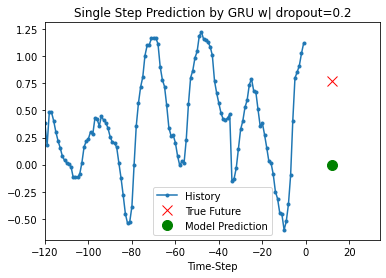

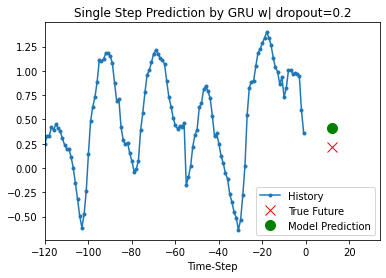

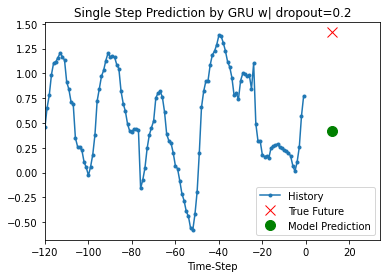

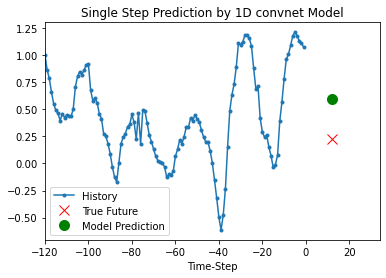

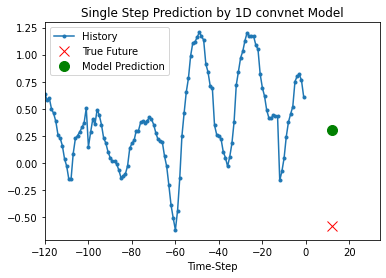

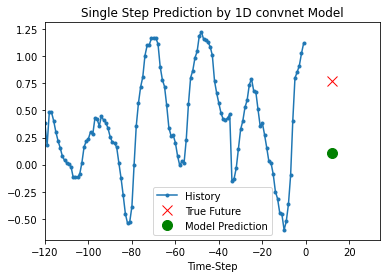

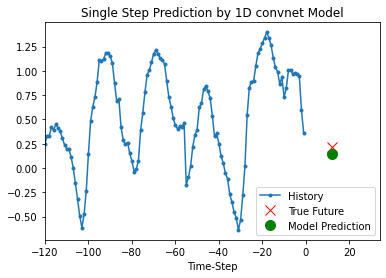

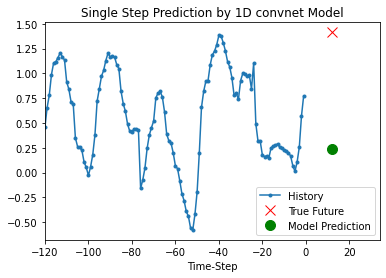

In [14]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],12,"Single Step Prediction",)
for x, y in dataset_val.take(5):
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), model_gru.predict(x)[0]],12,"Single Step Prediction by GRU Model",)
for x, y in dataset_val.take(5):
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), model_gru_drop.predict(x)[0]],12,"Single Step Prediction by GRU w| dropout=0.2",)
for x, y in dataset_val.take(5):
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), model_convnet.predict(x)[0]],12,"Single Step Prediction by 1D convnet Model",)